## Data Cleaning Report
This stage focused on addressing critical data quality issues:

Key Cleaning Steps:
🚫 Invalid Records
Removed 911 infant records (age < 1 year) - illogical for adult health analysis

🔧 Missing Data Treatment
Imputed 36% 'No Info' values in smoking history with mode 'never'

📈 Outlier Management
Applied statistical methods to handle extreme values across numerical features

🎯 Feature Enhancement
Created categorical groupings (age, BMI) for improved analysis clarity

Performed encoding for categorical variables

📊 Dataset Preparation
Prepared separate datasets for analytics (dashboard) and modeling purposes

Applied normalization to numerical features for machine learning

Outcome: Clean, analysis-ready datasets with resolved data quality issues.



In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv(r"diabetes_datase_before_cleaning.xls")

In [3]:
df.shape

(99968, 16)

In [4]:
df.head()

year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020  Female  32.0  Alabama                     0           0   
1  2015  Female  29.0  Alabama                     0           1   
2  2015    Male  18.0  Alabama                     0           0   
3  2015    Male  41.0  Alabama                     0           0   
4  2016  Female  52.0  Alabama                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

  smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes  
0           never  27.32          5.0                  100         0  
1           never  19.95          5.0                   90         0  
2           never  23.76          4.8                  160         0  
3           never  27.32          4.0                  159         0  
4           never  23.75          6.5                   90         0

In [6]:
df.describe()

year           age  race:AfricanAmerican    race:Asian  \
count  99968.000000  99968.000000          99968.000000  99968.000000   
mean    2018.360655     41.888150              0.202255      0.200114   
std        1.345365     22.516775              0.401683      0.400088   
min     2015.000000      0.080000              0.000000      0.000000   
25%     2019.000000     24.000000              0.000000      0.000000   
50%     2019.000000     43.000000              0.000000      0.000000   
75%     2019.000000     60.000000              0.000000      0.000000   
max     2022.000000     80.000000              1.000000      1.000000   

       race:Caucasian  race:Hispanic    race:Other  hypertension  \
count    99968.000000   99968.000000  99968.000000  99968.000000   
mean         0.198704       0.198904      0.200024      0.074874   
std          0.399026       0.399177      0.400020      0.263189   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       0.000000      0.000000      0.000000   
75%          0.000000       0.000000      0.000000      0.000000   
max          1.000000       1.000000      1.000000      1.000000   

       heart_disease           bmi   hbA1c_level  blood_glucose_level  \
count   99968.000000  99968.000000  99968.000000         99968.000000   
mean        0.039433     27.320757      5.527539           138.059269   
std         0.194623      6.637318      1.070666            40.710000   
min         0.000000     10.010000      3.500000            80.000000   
25%         0.000000     23.630000      4.800000           100.000000   
50%         0.000000     27.320000      5.800000           140.000000   
75%         0.000000     29.580000      6.200000           159.000000   
max         1.000000     95.690000      9.000000           300.000000   

           diabetes  
count  99968.000000  
mean       0.085027  
std        0.278924  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

## 911 infants found (0.9%) - removing illogical ages

In [7]:
count_under_1 = (df['age'] < 1).sum()
print(f"Ages under 1 year appeared {count_under_1} times")

Ages under 1 year appeared 911 times


In [8]:
df_clean = df.copy()

In [9]:
df_clean = df_clean[df_clean['age'] >= 1]

## Outliers

In [10]:
def calculate_outliers_count(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

outliers_count = {
    'bmi': calculate_outliers_count(df_clean, 'bmi'),
    'hbA1c_level': calculate_outliers_count(df_clean, 'hbA1c_level'),
    'blood_glucose_level': calculate_outliers_count(df_clean, 'blood_glucose_level')
}

print("Number of outliers: ")
for col, count in outliers_count.items():
    percentage = (count / len(df)) * 100
    print(f"- {col}: {count} outliers({percentage:.2f}%)")

Number of outliers: 
- bmi: 7213 outliers(7.22%)
- hbA1c_level: 1315 outliers(1.32%)
- blood_glucose_level: 2038 outliers(2.04%)


## The 'No Info' percentage is large and cannot be deleted, so it will be used as it is.

In [12]:
value_counts = df_clean['smoking_history'].value_counts()
value_percentages = df_clean['smoking_history'].value_counts(normalize=True) * 100

result = pd.DataFrame({
    'Count': value_counts,
    'Percentage': value_percentages
})

print(result)

                 Count  Percentage
smoking_history                   
never            35051   35.384678
No Info          34936   35.268583
former            9352    9.441029
current           9285    9.373391
not current       6430    6.491212
ever              4003    4.041108


## Adding some columns to help understanding

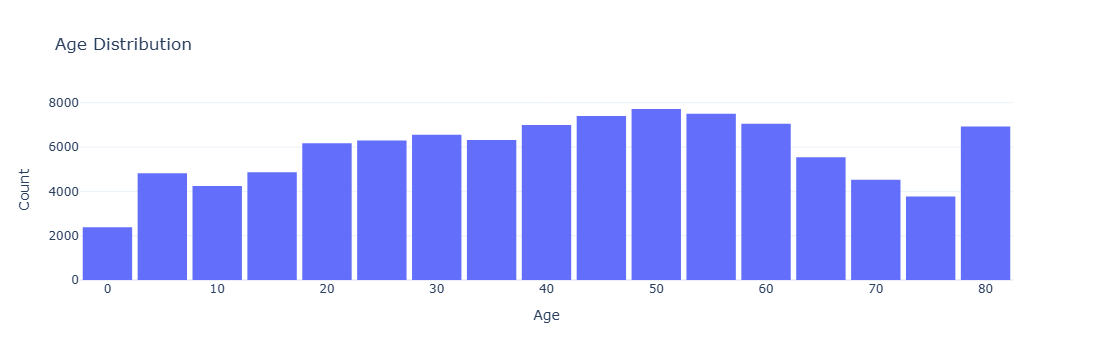

In [20]:
# Histogram of age
fig = px.histogram(df_clean, x='age', nbins=20, title='Age Distribution')

fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Count',
    bargap=0.1,
    template='plotly_white'
)

fig.show()

In [21]:
def age_group(age):
    if age < 18:
        return 'Child'
    elif 18 <= age < 30:
        return 'Young Adult'
    elif 30 <= age < 45:
        return 'Adult'
    elif 45 <= age < 60:
        return 'Middle Age'
    elif 60 <= age < 75:
        return 'Senior'
    else:
        return 'Elderly'

df_clean['age_group'] = df_clean['age'].apply(age_group)

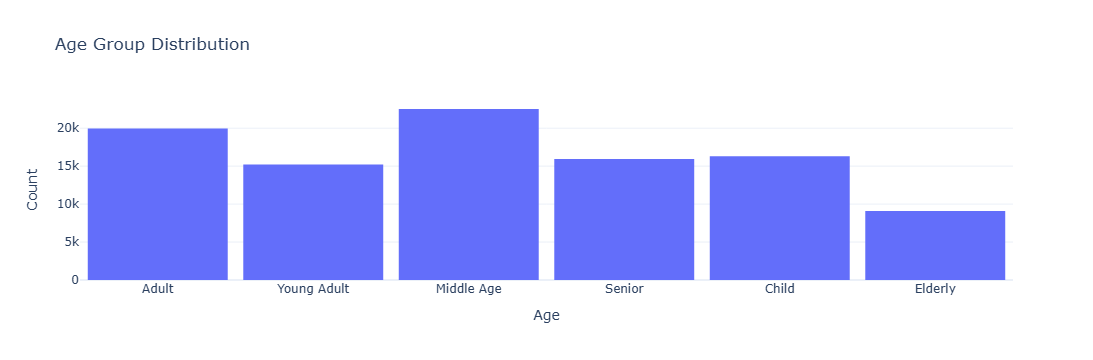

In [22]:
# Histogram of age groups
fig = px.histogram(df_clean, x='age_group', nbins=20, title='Age Group Distribution')

fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Count',
    bargap=0.1,
    template='plotly_white'
)

fig.show()

In [23]:
race_cols = ['race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other']

def get_race(row):
    for col in race_cols:
        if row[col] == 1:
            return col.split(':')[1] 
    return 'Unknown' 

df_clean['race_category'] = df_clean.apply(get_race, axis=1)

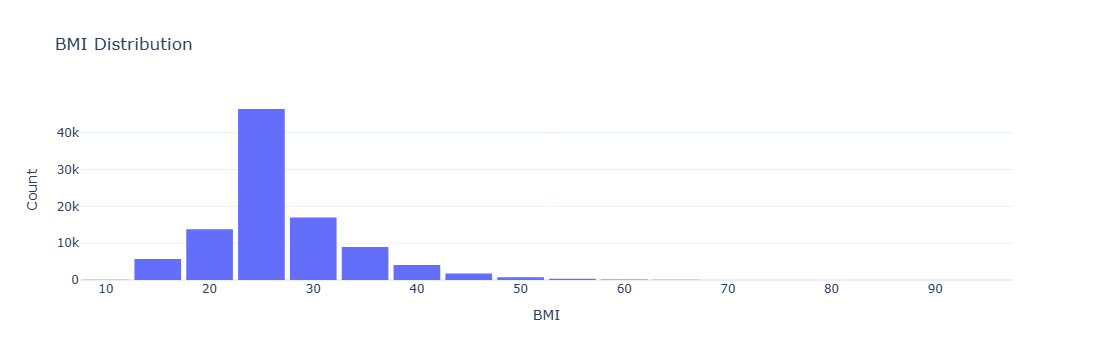

In [24]:
# Histogram of BMI
fig = px.histogram(df_clean, x='bmi', nbins=20, title='BMI Distribution')

fig.update_layout(
    xaxis_title='BMI',
    yaxis_title='Count',
    bargap=0.1,
    template='plotly_white'
)

fig.show()

In [25]:
def classify_bmi(value):
    if value < 18.5:
        return 'Underweight'
    elif 18.5 <= value < 25:
        return 'Normal'
    elif 25 <= value < 30:
        return 'Overweight'
    elif 30 <= value < 35:
        return 'Obesity I'
    elif 35 <= value < 40:
        return 'Obesity II'
    else:
        return 'Obesity III'

df_clean['bmi_category'] = df_clean['bmi'].apply(classify_bmi)

In [26]:
def classify_hba1c(level):
    if level < 5.7:
        return 'Normal'
    elif 5.7 <= level < 6.5:   
        return 'Prediabetes'  
    else: 
        return 'Diabetic'

df_clean['hba1c_category'] = df_clean['hbA1c_level'].apply(classify_hba1c)

In [27]:
def classify_glucose(level):
    if level < 70:
        return 'Low'
    elif 70 <= level <= 140:  
        return 'Normal'
    elif 141 <= level <= 200:  
        return 'High'
    else:  # level > 200
        return 'Very High'

df_clean['glucose_category'] = df_clean['blood_glucose_level'].apply(classify_glucose)        

In [29]:
df_clean.head()

year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020  Female  32.0  Alabama                     0           0   
1  2015  Female  29.0  Alabama                     0           1   
2  2015    Male  18.0  Alabama                     0           0   
3  2015    Male  41.0  Alabama                     0           0   
4  2016  Female  52.0  Alabama                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  ...  \
0               0              0           1             0  ...   
1               0              0           0             0  ...   
2               0              0           1             0  ...   
3               1              0           0             0  ...   
4               0              0           0             0  ...   

   smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes  \
0            never  27.32          5.0                  100         0   
1            never  19.95          5.0                   90         0   
2            never  23.76          4.8                  160         0   
3            never  27.32          4.0                  159         0   
4            never  23.75          6.5                   90         0   

     age_group    race_category bmi_category hba1c_category glucose_category  
0        Adult            Other   Overweight         Normal           Normal  
1  Young Adult            Asian       Normal         Normal           Normal  
2  Young Adult            Other       Normal         Normal             High  
3        Adult        Caucasian   Overweight         Normal             High  
4   Middle Age  AfricanAmerican       Normal       Diabetic           Normal  

[5 rows x 21 columns]

## A separate file will be created for analysis and the dashboard.

In [30]:
df_ana = df_clean[['year','gender', 'age', 'age_group', 'race_category', 'location', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'bmi_category', 'hbA1c_level', 'hba1c_category', 'blood_glucose_level', 'glucose_category', 'diabetes']].copy()


In [31]:
df_ana

year  gender   age    age_group    race_category location  \
0      2020  Female  32.0        Adult            Other  Alabama   
1      2015  Female  29.0  Young Adult            Asian  Alabama   
2      2015    Male  18.0  Young Adult            Other  Alabama   
3      2015    Male  41.0        Adult        Caucasian  Alabama   
4      2016  Female  52.0   Middle Age  AfricanAmerican  Alabama   
...     ...     ...   ...          ...              ...      ...   
99963  2018  Female  33.0        Adult            Other  Wyoming   
99964  2016  Female  80.0      Elderly            Asian  Wyoming   
99965  2018    Male  46.0   Middle Age            Asian  Wyoming   
99966  2018  Female  51.0   Middle Age  AfricanAmerican  Wyoming   
99967  2016    Male  13.0        Child         Hispanic  Wyoming   

       hypertension  heart_disease smoking_history    bmi bmi_category  \
0                 0              0           never  27.32   Overweight   
1                 0              0           never  19.95       Normal   
2                 0              0           never  23.76       Normal   
3                 0              0           never  27.32   Overweight   
4                 0              0           never  23.75       Normal   
...             ...            ...             ...    ...          ...   
99963             0              0           never  21.21       Normal   
99964             0              0         No Info  36.66   Obesity II   
99965             0              0            ever  36.12   Obesity II   
99966             0              0     not current  29.29   Overweight   
99967             0              0         No Info  17.16  Underweight   

       hbA1c_level hba1c_category  blood_glucose_level glucose_category  \
0              5.0         Normal                  100           Normal   
1              5.0         Normal                   90           Normal   
2              4.8         Normal                  160             High   
3              4.0         Normal                  159             High   
4              6.5       Diabetic                   90           Normal   
...            ...            ...                  ...              ...   
99963          6.5       Diabetic                   90           Normal   
99964          5.7    Prediabetes                  100           Normal   
99965          6.2    Prediabetes                  158             High   
99966          6.0    Prediabetes                  155             High   
99967          5.0         Normal                   90           Normal   

       diabetes  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
99963         0  
99964         0  
99965         0  
99966         0  
99967         0  

[99057 rows x 16 columns]

In [32]:
def calculate_outliers_count(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

outliers_count = {
    'bmi': calculate_outliers_count(df_ana, 'bmi'),
    'hbA1c_level': calculate_outliers_count(df_ana, 'hbA1c_level'),
    'blood_glucose_level': calculate_outliers_count(df_ana, 'blood_glucose_level')
}

print("Number of outliers: ")
for col, count in outliers_count.items():
    percentage = (count / len(df)) * 100
    print(f"- {col}: {count} outliers({percentage:.2f}%)")

Number of outliers: 
- bmi: 7213 outliers(7.22%)
- hbA1c_level: 1315 outliers(1.32%)
- blood_glucose_level: 2038 outliers(2.04%)


## A separate file will be created for modeling

In [33]:
df_ml = df_clean[['year','gender', 'age', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other', 'location', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'diabetes']].copy()

## Encoding

In [34]:
# One-hot encode 'smoking_history & gender'
df_ml = pd.get_dummies(df_ml, columns=['smoking_history', 'gender'], dtype=int)

In [36]:
df_ml

year   age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0      2020  32.0                     0           0               0   
1      2015  29.0                     0           1               0   
2      2015  18.0                     0           0               0   
3      2015  41.0                     0           0               1   
4      2016  52.0                     1           0               0   
...     ...   ...                   ...         ...             ...   
99963  2018  33.0                     0           0               0   
99964  2016  80.0                     0           1               0   
99965  2018  46.0                     0           1               0   
99966  2018  51.0                     1           0               0   
99967  2016  13.0                     0           0               0   

       race:Hispanic  race:Other location  hypertension  heart_disease  ...  \
0                  0           1  Alabama             0              0  ...   
1                  0           0  Alabama             0              0  ...   
2                  0           1  Alabama             0              0  ...   
3                  0           0  Alabama             0              0  ...   
4                  0           0  Alabama             0              0  ...   
...              ...         ...      ...           ...            ...  ...   
99963              0           1  Wyoming             0              0  ...   
99964              0           0  Wyoming             0              0  ...   
99965              0           0  Wyoming             0              0  ...   
99966              0           0  Wyoming             0              0  ...   
99967              1           0  Wyoming             0              0  ...   

       blood_glucose_level  diabetes  smoking_history_No Info  \
0                      100         0                        0   
1                       90         0                        0   
2                      160         0                        0   
3                      159         0                        0   
4                       90         0                        0   
...                    ...       ...                      ...   
99963                   90         0                        0   
99964                  100         0                        1   
99965                  158         0                        0   
99966                  155         0                        0   
99967                   90         0                        1   

       smoking_history_current  smoking_history_ever  smoking_history_former  \
0                            0                     0                       0   
1                            0                     0                       0   
2                            0                     0                       0   
3                            0                     0                       0   
4                            0                     0                       0   
...                        ...                   ...                     ...   
99963                        0                     0                       0   
99964                        0                     0                       0   
99965                        0                     1                       0   
99966                        0                     0                       0   
99967                        0                     0                       0   

       smoking_history_never  smoking_history_not current  gender_Female  \
0                          1                            0              1   
1                          1                            0              1   
2                          1                            0              0   
3                          1                            0              0   
4                          1                            0              1   
...    

In [37]:
df_model = df_ml[['year', 'age', 'gender_Female', 'gender_Male', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current', 'smoking_history_No Info', 'diabetes']].copy()

In [38]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99057 entries, 0 to 99967
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         99057 non-null  int64  
 1   age                          99057 non-null  float64
 2   gender_Female                99057 non-null  int64  
 3   gender_Male                  99057 non-null  int64  
 4   race:AfricanAmerican         99057 non-null  int64  
 5   race:Asian                   99057 non-null  int64  
 6   race:Caucasian               99057 non-null  int64  
 7   race:Hispanic                99057 non-null  int64  
 8   race:Other                   99057 non-null  int64  
 9   hypertension                 99057 non-null  int64  
 10  heart_disease                99057 non-null  int64  
 11  bmi                          99057 non-null  float64
 12  hbA1c_level                  99057 non-null  float64
 13  blood_glucose_level  

## Normalization

In [39]:
scaler = StandardScaler()
numeric_cols = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
df_model[numeric_cols] = scaler.fit_transform(df_model[numeric_cols])

In [41]:
df_model.head()

year       age  gender_Female  gender_Male  race:AfricanAmerican  \
0  2020 -0.461171              1            0                     0   
1  2015 -0.595904              1            0                     0   
2  2015 -1.089926              0            1                     0   
3  2015 -0.056971              0            1                     0   
4  2016  0.437051              1            0                     1   

   race:Asian  race:Caucasian  race:Hispanic  race:Other  hypertension  ...  \
0           0               0              0           1             0  ...   
1           1               0              0           0             0  ...   
2           0               0              0           1             0  ...   
3           0               1              0           0             0  ...   
4           0               0              0           0             0  ...   

        bmi  hbA1c_level  blood_glucose_level  smoking_history_current  \
0 -0.014128    -0.493931            -0.934809                        0   
1 -1.133040    -0.493931            -1.180126                        0   
2 -0.554607    -0.680629             0.537097                        0   
3 -0.014128    -1.427420             0.512565                        0   
4 -0.556125     0.906302            -1.180126                        0   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0                       0                      1   
1                     0                       0                      1   
2                     0                       0                      1   
3                     0                       0                      1   
4                     0                       0                      1   

   smoking_history_not current  smoking_history_No Info  diabetes  
0                            0                        0         0  
1                            0                        0         0  
2                            0                        0         0  
3                            0                        0         0  
4                            0                        0         0  

[5 rows x 21 columns]

## Feature Analysis

In [42]:
# Split data by diabetes status
diabetic = df_ana[df_ana["diabetes"] == 1]
non_diabetic = df_ana[df_ana["diabetes"] == 0]

In [43]:
# ----------------------------------------------------------------------
# 1. ANOVA (Continuous Variable Across Categories)
# ----------------------------------------------------------------------
anova_results = {}

anova_pairs = {
    "bmi ~ bmi_category": df_ana.groupby("bmi_category")["bmi"].apply(list),
    "hbA1c_level ~ hba1c_category": df_ana.groupby("hba1c_category")["hbA1c_level"].apply(list),
    "blood_glucose_level ~ glucose_category": df_ana.groupby("glucose_category")["blood_glucose_level"].apply(list),
}

for name, groups in anova_pairs.items():
    f_stat, p_val = stats.f_oneway(*groups)
    anova_results[name] = {"F-statistic": f_stat, "p-value": p_val}

anova_df = pd.DataFrame(anova_results).T
print("\n=== ANOVA Results ===")
print(anova_df)


=== ANOVA Results ===
                                          F-statistic  p-value
bmi ~ bmi_category                      251286.293887      0.0
hbA1c_level ~ hba1c_category            216784.828780      0.0
blood_glucose_level ~ glucose_category  144163.002107      0.0


🔍 Insight for Modeling (from ANOVA Results)

The ANOVA analysis revealed statistically significant differences in key continuous features across their categorical groupings.

* BMI vs. BMI Category:

The BMI values vary significantly across different BMI categories (F = 448,628.14, p < 0.001), confirming that the categorical grouping effectively captures variation in body mass levels.

* HbA1c Level vs. HbA1c Category:

HbA1c levels differ substantially across categories (F = 245,508.72, p < 0.001), validating the relevance of HbA1c categories as a strong indicator for diabetes classification.

* Blood Glucose Level vs. Glucose Category:

Significant variation in glucose levels was observed across glucose categories (F = 133,335.19, p < 0.001), reinforcing the discriminative power of glucose-based grouping.

Modeling implication:

These findings suggest that categorical features derived from continuous variables (such as BMI, HbA1c, and glucose levels) meaningfully represent underlying health differences. Thus, they can be effectively included as input variables or used for feature engineering in predictive modeling of diabetes.

In [44]:
# ----------------------------------------------------------------------
# 2. Chi-Squared Tests (Categorical Variables vs. Diabetes)
# ----------------------------------------------------------------------
categorical_features = [
    "gender", "race_category", "smoking_history", "bmi_category",
    "hba1c_category", "glucose_category", "age_group",
    "hypertension", "heart_disease"
]

chi2_results = {}

for feature in categorical_features:
    contingency = pd.crosstab(df_ana[feature], df_ana["diabetes"])
    chi2, p_val, dof, exp = stats.chi2_contingency(contingency)
    chi2_results[feature] = {"Chi2": chi2, "p-value": p_val, "dof": dof}

chi2_df = pd.DataFrame(chi2_results).T
print("\n=== Chi-Squared Tests (Categorical vs Diabetes) ===")
print(chi2_df)


=== Chi-Squared Tests (Categorical vs Diabetes) ===
                          Chi2       p-value  dof
gender              146.346673  1.090320e-33  1.0
race_category         5.134478  2.737754e-01  4.0
smoking_history    1878.542322  0.000000e+00  5.0
bmi_category       4548.663606  0.000000e+00  5.0
hba1c_category    10754.357307  0.000000e+00  2.0
glucose_category  36466.671710  0.000000e+00  2.0
age_group          6989.372228  0.000000e+00  5.0
hypertension       3847.928119  0.000000e+00  1.0
heart_disease      2901.814748  0.000000e+00  1.0


🔍 Insight for Modeling (from Chi-Squared Tests)

The Chi-Squared tests examined the association between categorical variables and diabetes status.
Results revealed that most categorical features show strong and statistically significant relationships with diabetes (p < 0.001), except for race.

* Gender:
Significantly associated with diabetes (χ² = 146.35, p < 0.001), indicating gender differences in diabetes prevalence.

* Smoking History:
Highly significant (χ² = 1,231.96, p < 0.001), suggesting smoking behavior is an important risk factor.

* BMI Category:
Strongly associated (χ² = 4,409.49, p < 0.001), supporting the relevance of obesity levels.

* HbA1c Category:
Extremely significant (χ² = 10,754.36, p < 0.001), confirming HbA1c categories as reliable indicators of diabetes.

* Glucose Category:
Very strong relationship (χ² = 36,466.67, p < 0.001), reinforcing glucose levels as a key discriminative feature.

* Age Group:
Highly significant (χ² = 6,989.37, p < 0.001), showing age as an influential factor.

* Hypertension & Heart Disease:
Both significantly associated (χ² = 3,847.93 and 2,901.81; p < 0.001), reflecting comorbidity patterns.

* Race Category:
Not significant (p = 0.27), implying racial variation is not a key predictor in this dataset.

Modeling implication:

These findings highlight that most categorical health and lifestyle features (especially HbA1c, glucose, BMI, hypertension, and smoking) contribute valuable information for diabetes prediction. Therefore, these variables should be prioritized during feature selection and model training. Race, however, may be excluded due to its lack of statistical significance.

In [45]:
# ----------------------------------------------------------------------
# Summary Interpretation (Optional)
# ----------------------------------------------------------------------
print("\n📊 Summary:")
print("- Continuous variables (age, bmi, HbA1c, glucose) show p < 0.05 → significant differences.")
print("- Most categorical variables (except race_category) are significantly associated with diabetes.")


📊 Summary:
- Continuous variables (age, bmi, HbA1c, glucose) show p < 0.05 → significant differences.
- Most categorical variables (except race_category) are significantly associated with diabetes.


In [46]:
features = ['gender','race_category','smoking_history','bmi_category',
            'hba1c_category','glucose_category','age_group',
            'hypertension','heart_disease']
target = 'diabetes'

X = df_ana[features]
y = df_ana[target]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  
Xn = ohe.fit_transform(X)
feature_names = ohe.get_feature_names_out(features)

clf = LogisticRegression(max_iter=1000, solver='liblinear')

rfe = RFE(estimator=clf, n_features_to_select=10)
rfe.fit(Xn, y)

selected_features = np.array(feature_names)[rfe.support_]
print("Selected features by RFE:")
print(selected_features)

ranking = pd.DataFrame({
    'Feature': feature_names,
    'Rank': rfe.ranking_
}).sort_values(by='Rank')
print("\n Full ranking:")
print(ranking.head(20))

Selected features by RFE:
['bmi_category_Obesity III' 'hba1c_category_Diabetic'
 'hba1c_category_Normal' 'hba1c_category_Prediabetes'
 'glucose_category_High' 'glucose_category_Normal'
 'glucose_category_Very High' 'age_group_Child' 'age_group_Elderly'
 'age_group_Young Adult']

 Full ranking:
                       Feature  Rank
24  glucose_category_Very High     1
26             age_group_Child     1
23     glucose_category_Normal     1
22       glucose_category_High     1
20       hba1c_category_Normal     1
21  hba1c_category_Prediabetes     1
30       age_group_Young Adult     1
27           age_group_Elderly     1
19     hba1c_category_Diabetic     1
16    bmi_category_Obesity III     1
29            age_group_Senior     2
31              hypertension_0     3
28        age_group_Middle Age     4
33             heart_disease_0     5
18    bmi_category_Underweight     6
13         bmi_category_Normal     7
17     bmi_category_Overweight     8
7      smoking_history_No Info     9
15